# Extract ingredients and nutrients of each recipe（可以从第二部分开始）

In [1]:
import pandas as pd
import os

path = './extracted_data/'
data = pd.DataFrame()

for path, subpath, files in os.walk(path):
    files.sort()
    for i in files:
        if i.endswith("csv"):
            d2 = pd.read_csv(path + '/' + i)
            # integrate csv files of different categories into one table
            data = data.append(d2, ignore_index=True)

data

,title,image,ingredients,nutrients
0,15-minute chicken & halloumi burgers,https://images.immediate.co.uk/production/vola...,"['2 skinless chicken breasts', '1 tbsp oil , p...","{'calories': '737 calories', 'fatContent': '42..."
1,Soft burger buns,https://images.immediate.co.uk/production/vola...,"['200ml whole milk , plus extra for brushing',...","{'calories': '210 calories', 'fatContent': '5 ..."
2,Molten cheese-stuffed burgers,https://images.immediate.co.uk/production/vola...,"['1½ tbsp olive oil', '1 onion , very finely c...","{'calories': '654 calories', 'fatContent': '49..."
3,Halloumi burgers,https://images.immediate.co.uk/production/vola...,"['250g block halloumi cheese, cut into 8 thick...","{'calories': '455 calories', 'fatContent': '30..."
4,Vegan burger,https://images.immediate.co.uk/production/vola...,"['1 shallot or ½ onion, chopped', '1 stick of ...","{'calories': '190 calories', 'fatContent': '8 ..."
...,...,...,...,...
1995,Cake of kings,https://images.immediate.co.uk/production/vola...,"['85g citrus candied peel , chopped', '100g ra...","{'calories': '252 calories', 'fatContent': '8 ..."
1996,Homemade buttermilk,https://images.immediate.co.uk/production/vola...,"['250ml whole or semi-skimmed milk', '1 tbsp l...","{'calories': '60 calories', 'fatContent': '3 g..."
1997,Festive frozen chocolate parfait,https://images.immediate.co.uk/production/vola...,"['100g dried cranberries', '150g raisins or su...","{'calories': '548 calories', 'fatContent': '33..."
1998,Christmas cake soufflés,https://images.immediate.co.uk/production/vola...,"['butter , for greasing', '1 tbsp golden caste...","{'calories': '158 calories', 'fatContent': '5 ..."


# Ingredient extraction

In [2]:
def clean_recipe(ingred_list):
    cleanedtext = []
    ingred_list = ast.literal_eval(ingred_list)
    
    for matchtext in ingred_list:
        
        # 怎么去除 ½, ¼, %等
        #for r in (('½', "1/2"), ("¼", "1/4")):
        #    matchtext = matchtext.replace(*r)
        
        
        # Obtain all before first comma
        if re.compile('^(.+?)(?=,)').search(matchtext) is not None:
            matchtext = re.compile('^(.+?)(?=,)').search(matchtext).group(1)
        
        
        # Tokenize ingredient list
        tokenized = word_tokenize(matchtext)
        
        # Remove words likely to be stop words or measurements
        removed_stop = [w for w in tokenized if not w in measure_corpus]
        removed_stop = [w for w in removed_stop if not w in stop_words]
        
        # Filter adjectives and nouns
        ingred_words = lambda pos: pos[:2] in ['JJ','NN','NNS']
        ingreds = [word.lower() for (word, pos) in pos_tag(removed_stop) if ingred_words(pos)]
        
        # Convert to singular
        ingreds = [p.singular_noun(word) if p.singular_noun(word) else word for word in ingreds]
        
        # remove special characters (including numbers!)怎么去除 ½, ¼, %等
        #cleanedtext = re.sub('[^a-zA-Z]', '', cleanedtext)
        ingreds = [re.sub('[^ a-zA-Z]', '', i) for i in ingreds]
        #print(ingreds)
        
        # Remove common ingredients 
        common = []
        cleanedtext.append(ingreds)
        cleanedtext = [[ing for ing in ingreds if not any(word in common for word in ingreds)] for ingreds in cleanedtext]
        
        # Remove additional descriptors for long ingredient names
        cleanedtext = [ingreds[-2:] if len(ingreds) > 2 else ingreds for ingreds in cleanedtext]
        

        
    return [(' ').join(item) for item in cleanedtext if len(item)>0]
    #return [(' ').join(item) for item in cleanedtext if len(item)>0 and item!=['']]

In [3]:
# extract ingredients from each recipe

from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk import pos_tag
import re
import requests
from bs4 import BeautifulSoup
import ast
import inflect

p = inflect.engine()
stop_words = set(stopwords.words('english'))

df = data[['ingredients']]

page = requests.get('https://www.enchantedlearning.com/wordlist/measurement.shtml')
soup = BeautifulSoup(page.content, "html.parser")
measure_corpus = [tag.text for tag in soup.find_all('div',attrs={'class':'wordlist-item'})]
measure_corpus = measure_corpus + [text+'s' for text in measure_corpus] + \
            ['taste','strip', 'strips', 'package', 'packages', 'satchet', \
             'satchets', 'sprigs', 'head', 'bunch', 'small', 'large', 'big', 'medium', 'tbsp', 'g']

#clean_recipe(ast.literal_eval(data.astype(str)['ingredients'][0]))
df['ingredients'] = df['ingredients'].apply(clean_recipe)

df = df.rename(columns={"ingredients": "parsed_ingredients"})
#data = data.join(df)
#data.to_csv('./data.csv')
#data
df.head()

<ipython-input-3-5f09f6fd6033>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ingredients'] = df['ingredients'].apply(clean_recipe)


,parsed_ingredients
0,"[chicken breast, oil, chilli sauce, lemon, bu..."
1,"[whole milk, unsalted butter, plain flour, cas..."
2,"[olive oil, onion, pancetta, garlic clove, thy..."
3,"[halloumi cheese, olive oil, brioche bun, humm..."
4,"[shallot onion, stick celery, parsley leaf, ch..."


In [4]:
data = data.join(df)
data.to_csv('./data.csv', index=False)
data

,title,image,ingredients,nutrients,parsed_ingredients
0,15-minute chicken & halloumi burgers,https://images.immediate.co.uk/production/vola...,"['2 skinless chicken breasts', '1 tbsp oil , p...","{'calories': '737 calories', 'fatContent': '42...","[chicken breast, oil, chilli sauce, lemon, bu..."
1,Soft burger buns,https://images.immediate.co.uk/production/vola...,"['200ml whole milk , plus extra for brushing',...","{'calories': '210 calories', 'fatContent': '5 ...","[whole milk, unsalted butter, plain flour, cas..."
2,Molten cheese-stuffed burgers,https://images.immediate.co.uk/production/vola...,"['1½ tbsp olive oil', '1 onion , very finely c...","{'calories': '654 calories', 'fatContent': '49...","[olive oil, onion, pancetta, garlic clove, thy..."
3,Halloumi burgers,https://images.immediate.co.uk/production/vola...,"['250g block halloumi cheese, cut into 8 thick...","{'calories': '455 calories', 'fatContent': '30...","[halloumi cheese, olive oil, brioche bun, humm..."
4,Vegan burger,https://images.immediate.co.uk/production/vola...,"['1 shallot or ½ onion, chopped', '1 stick of ...","{'calories': '190 calories', 'fatContent': '8 ...","[shallot onion, stick celery, parsley leaf, ch..."
...,...,...,...,...,...
1995,Cake of kings,https://images.immediate.co.uk/production/vola...,"['85g citrus candied peel , chopped', '100g ra...","{'calories': '252 calories', 'fatContent': '8 ...","[citru peel, raisin, pine nut, glac cherry, sh..."
1996,Homemade buttermilk,https://images.immediate.co.uk/production/vola...,"['250ml whole or semi-skimmed milk', '1 tbsp l...","{'calories': '60 calories', 'fatContent': '3 g...","[semiskimmed milk, juice vinegar]"
1997,Festive frozen chocolate parfait,https://images.immediate.co.uk/production/vola...,"['100g dried cranberries', '150g raisins or su...","{'calories': '548 calories', 'fatContent': '33...","[dried cranberry, raisin sultana, brandy, dark..."
1998,Christmas cake soufflés,https://images.immediate.co.uk/production/vola...,"['butter , for greasing', '1 tbsp golden caste...","{'calories': '158 calories', 'fatContent': '5 ...","[butter, caster sugar, egg white, readymade cu..."


# Count frequency and Turn ingredients into vectors

In [14]:
import pandas as pd
import ast

data = pd.read_csv('./data.csv')
#data = data[['parsed_ingredients']]
data.head()

,title,image,ingredients,nutrients,parsed_ingredients
0,15-minute chicken & halloumi burgers,https://images.immediate.co.uk/production/vola...,"['2 skinless chicken breasts', '1 tbsp oil , p...","{'calories': '737 calories', 'fatContent': '42...","['chicken breast', 'oil', 'chilli sauce', ' le..."
1,Soft burger buns,https://images.immediate.co.uk/production/vola...,"['200ml whole milk , plus extra for brushing',...","{'calories': '210 calories', 'fatContent': '5 ...","['whole milk', 'unsalted butter', 'plain flour..."
2,Molten cheese-stuffed burgers,https://images.immediate.co.uk/production/vola...,"['1½ tbsp olive oil', '1 onion , very finely c...","{'calories': '654 calories', 'fatContent': '49...","['olive oil', 'onion', 'pancetta', 'garlic clo..."
3,Halloumi burgers,https://images.immediate.co.uk/production/vola...,"['250g block halloumi cheese, cut into 8 thick...","{'calories': '455 calories', 'fatContent': '30...","['halloumi cheese', 'olive oil', 'brioche bun'..."
4,Vegan burger,https://images.immediate.co.uk/production/vola...,"['1 shallot or ½ onion, chopped', '1 stick of ...","{'calories': '190 calories', 'fatContent': '8 ...","['shallot onion', 'stick celery', 'parsley lea..."


In [15]:
# count the frequency of each ingredient

dic = {}
top_ingredients = 20

for ingredient in data['parsed_ingredients']:
    
    temp_list = ast.literal_eval(ingredient)
    for item in temp_list:
        try:
            dic[str(item)] += 1
        except:
            dic[str(item)] = 1

dic_sorted = sorted(dic.items(),key=lambda item:item[1], reverse=True)

# find most common top 10 ingredients
top_ingredient = []

for (i,j) in dic_sorted[:top_ingredients]:
    top_ingredient.append(i)
    
dic_sorted[:top_ingredients]

[('olive oil', 811),
 ('egg', 735),
 ('caster sugar', 645),
 ('butter', 551),
 ('garlic clove', 394),
 ('selfraising flour', 346),
 ('red onion', 290),
 ('icing sugar', 289),
 ('plain flour', 272),
 ('wine vinegar', 242),
 ('spring onion', 234),
 ('vanilla extract', 228),
 ('juice lemon', 225),
 ('unsalted butter', 205),
 ('baking powder', 205),
 ('milk', 205),
 ('double cream', 161),
 ('lemon', 157),
 ('carrot', 148),
 ('rapeseed oil', 137)]

In [16]:
# turn ingredients of each recipe into vector
import numpy as np

ingre_vectors = []

for parsed_ingre in data['parsed_ingredients']:
    
    ingres = ast.literal_eval(parsed_ingre)
    ingre_vector = top_ingredients * [0]
    
    for ingre in ingres:
        if ingre in top_ingredient:
            ingre_vector[top_ingredient.index(ingre)] = 1
    
    ingre_vectors.append(ingre_vector)
    

#print(len(ingre_vectors))
ingre_vectors = np.asarray(ingre_vectors)
ingre_vectors.shape

(2000, 20)

# Nutrient information extraction

{'calories': '737 calories', 
 'fatContent': '42 grams fat', 
 'saturatedFatContent': '10 grams saturated fat', 
 'carbohydrateContent': '49 grams carbohydrates', 
 'sugarContent': '6 grams sugar', 
 'fiberContent': '4 grams fiber', 
 'proteinContent': '39 grams protein', 
 'sodiumContent': '4.1 milligram of sodium'}

In [17]:
# extract nutrient information as target for training

import ast
import re
import numpy as np

nutrient_information = []

for nutrients in data['nutrients']:
    # convert string to dictionary
    data_dict = ast.literal_eval(nutrients)
    # data_dict.values()
    # find numerical values of each nutrients
    nutrient = re.findall('[\d+\.\d+]+', str(data_dict.values()))
    nutrient = [float(num) for num in nutrient]
    nutrient_information.append(nutrient)

#print(len(nutrient_information))
nutrient_information = np.asarray(nutrient_information)
nutrient_information.shape
#np.asarray(nutrient_information)[0]

/usr/local/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


(2000,)

In [18]:
# remove those with incomplete nutients

j = 0
drop_index = []

for i in nutrient_information:
    if len(i) < 8:
        drop_index.append(j)
    j+=1


nutrient_information = [i for j, i in enumerate(nutrient_information) if j not in drop_index]
nutrient_information = np.asarray(nutrient_information)
print(nutrient_information.shape)

(1773, 8)


In [19]:
# remove corresponding ingredients

print(len(ingre_vectors))
ingre_vectors = [i for j, i in enumerate(ingre_vectors) if j not in drop_index]
ingre_vectors = np.asarray(ingre_vectors)
print(ingre_vectors.shape)

2000
(1773, 20)


# Combine nutrients and ingredients as target output for training

# Read images

In [7]:
import os
import numpy as np
from PIL import Image
import re

# sort image name by number
def sort_key(s):
    try:
        c = re.findall('\d+', s)[0]
    except:
        c = -1
    return int(c)


def load_image(path, img_height, img_width):
    # load images from directory and resize to tagert size for training network
    imgs = []
    # walk through base-folder and subfolders
    for path, subpath, files in os.walk(path):
        files.sort(key=sort_key)
        #print(path, files)
        for i in files:
            if i.endswith("jpg") or i.endswith("png"):
                # print(i)
                img = Image.open(path + "/" +i).resize((img_width, img_height))
                if np.asarray(img).shape != (224,224,3):
                    img = Image.open(path + "/" +i).convert('RGB').resize((img_width, img_height))
                imgs.append(np.asarray(img))
    
    return np.asarray(imgs)


path = './extracted_data/'
img_width = 224
img_height = 224

imgs = load_image(path, img_height, img_width)
print(imgs.shape)

imgs = [i for j, i in enumerate(imgs) if j not in drop_index]
imgs = np.asarray(imgs)
print(imgs.shape)

/usr/local/lib/python3.8/site-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


(2000, 224, 224, 3)
(1773, 224, 224, 3)


In [ ]:
# 看图片标签是不是对齐的！

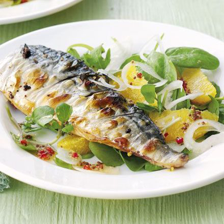

In [22]:
num = 1000
Image.fromarray(imgs[num])

In [23]:
print(nutrient_information[num])
print(ingre_vectors[num])

[4.12e+02 2.50e+01 5.00e+00 1.80e+01 1.70e+01 3.00e+00 3.00e+01 3.20e-01]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [8]:
# preprocess images

normalized_imgs = imgs / 255
# normalized_imgs

# Build network

In [9]:
from keras.models import Model
from keras.layers import Dense, Input, Flatten, concatenate
from keras.applications.densenet import DenseNet121

base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)

nutrient_pred = Dense(8, name='nutrients')(x)
ingre_pred = Dense(top_ingredients, activation = "sigmoid", name='ingredients')(x)

#out = concatenate([branchA, branchB])

model = Model(inputs=base_model.input, outputs=[nutrient_pred, ingre_pred])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
______________________________________________________________________________________________

In [11]:
from keras.optimizers import Adam

model.compile(optimizer=Adam(lr=1e-4), loss={'nutrients':'mse', 'ingredients':'binary_crossentropy'}, 
              metrics=['accuracy'])
model.fit(normalized_imgs, [nutrient_information, ingre_vectors], 
          validation_split=0.1, epochs=2, verbose=1, batch_size=1)


Epoch 1/2
1254/1254 [==============================] - 152s 118ms/step - loss: 4828.1814 - nutrients_loss: 4826.9079 - ingredients_loss: 1.2734 - nutrients_accuracy: 1.0000 - ingredients_accuracy: 0.2890 - val_loss: 4120.6846 - val_nutrients_loss: 4119.8257 - val_ingredients_loss: 0.8587 - val_nutrients_accuracy: 1.0000 - val_ingredients_accuracy: 0.3357
Epoch 2/2
1254/1254 [==============================] - 142s 114ms/step - loss: 4862.5595 - nutrients_loss: 4861.6175 - ingredients_loss: 0.9427 - nutrients_accuracy: 1.0000 - ingredients_accuracy: 0.3873 - val_loss: 4029.7080 - val_nutrients_loss: 4028.9634 - val_ingredients_loss: 0.7434 - val_nutrients_accuracy: 1.0000 - val_ingredients_accuracy: 0.4571


In [67]:
model.save('./burger_first.h5')

# save model and history
#import pickle

#with open('./model_and_history/final3_perceptual_unknown_4848_12000_subpixel_X2.pkl','wb') as f:
    #pickle.dump(history.history, f)

#model.save_weights('./model_and_history/final_mse_unknown_4848_12000_subpixel_X4 _weights.hdf5')
#model.save('./model_and_history/perceptual_baseline1_3232_model.h5')

In [65]:
model.predict(np.expand_dims(normalized_imgs[0], axis=0))

[array([[375.68787  ,  33.96759  ,   1.8816065,  10.414915 ,  17.008928 ,
           3.2797508,  13.754762 ,   1.3811593]], dtype=float32),
 array([[1.23648286e-01, 1.00000000e+00, 0.00000000e+00, 8.03497434e-03,
         5.40461123e-01, 1.00000000e+00, 4.21894399e-26, 1.13232225e-01,
         1.00000000e+00, 1.90166916e-20]], dtype=float32)]

In [12]:
model.predict(np.expand_dims(normalized_imgs[0], axis=0))

[array([[4.4261505e+02, 2.4797510e+01, 8.7308254e+00, 3.2968742e+01,
         1.3308223e+01, 3.9988034e+00, 2.2814510e+01, 2.7198830e-01]],
       dtype=float32),
 array([[4.7885105e-01, 1.0450259e-01, 5.1347226e-02, 2.5539711e-01,
         3.4886116e-01, 3.6915123e-02, 2.6813054e-01, 1.6838061e-12,
         7.8342795e-02, 4.5565665e-03]], dtype=float32)]

In [66]:
print(nutrient_information[0])
print(ingre_vectors[0])

[737.0, 42.0, 10.0, 49.0, 6.0, 4.0, 39.0, 4.1]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1]


In [56]:
model.predict(np.expand_dims(normalized_imgs[1], axis=0))

[array([[447.1117  ,  22.333237,   8.505314,  34.968132,   8.990719,
           4.908481,  18.69693 ,   1.106297]], dtype=float32),
 array([[0.07517844, 0.01071006, 0.5140303 , 0.07496288, 0.10428992,
         0.27532104, 0.30711216, 0.00156835, 0.01391488, 0.04083109]],
       dtype=float32)]

In [13]:
model.predict(np.expand_dims(normalized_imgs[1], axis=0))

[array([[417.40295  ,  18.817368 ,   8.588995 ,  37.723248 ,  11.250804 ,
           2.8133042,  17.200981 ,   5.309262 ]], dtype=float32),
 array([[6.0313046e-03, 7.9127848e-03, 5.5845326e-01, 3.8940400e-02,
         3.0152231e-02, 2.8474146e-01, 2.7315974e-02, 3.6718496e-11,
         4.6793133e-02, 3.7315071e-02]], dtype=float32)]

In [61]:
print(nutrient_information[1])
print(ingre_vectors[1])

[210.0, 5.0, 3.0, 35.0, 3.0, 2.0, 6.0, 0.4]
[0, 0, 0, 1, 1, 0, 0, 1, 1, 0]


In [58]:
model.predict(np.expand_dims(normalized_imgs[2], axis=0))

[array([[543.6993   ,  30.295036 ,  11.072008 ,  38.086296 ,  15.041439 ,
           2.8207948,  26.638327 ,   1.0462105]], dtype=float32),
 array([[0.77807677, 0.02893487, 0.0482401 , 0.7154445 , 0.02434561,
         0.04901221, 0.00301099, 0.03756481, 0.03010523, 0.2657691 ]],
       dtype=float32)]

In [62]:
print(nutrient_information[2])
print(ingre_vectors[2])

[654.0, 49.0, 13.0, 11.0, 4.0, 2.0, 40.0, 2.1]
[0, 1, 1, 0, 0, 1, 0, 0, 0, 1]
